In [1]:
!pip install scikit-fuzzy numpy matplotlib


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [10]:
def initialize_membership_matrix(n_samples, n_clusters):
    """Инициализация матрицы принадлежности случайными значениями"""
    U = np.random.dirichlet(np.ones(n_clusters), size=n_samples).T
    return U

def compute_centroids(data, U, m):
    """Вычисление центроидов кластеров"""
    um = U ** m
    return (um @ data) / np.sum(um, axis=1, keepdims=True)

def update_membership_matrix(data, centroids, m):
    """Обновление матрицы принадлежности"""
    distances = np.linalg.norm(data[:, np.newaxis, :] - centroids, axis=2)
    distances = np.fmax(distances, np.finfo(np.float64).eps)
    inv_distances = distances ** (-2 / (m - 1))
    return inv_distances / np.sum(inv_distances, axis=1, keepdims=True)

def fuzzy_c_means(data, n_clusters=3, m=2, error=1e-5, max_iter=1000):
    """Алгоритм нечеткой кластеризации C-средних"""
    n_samples = data.shape[0]
    U = initialize_membership_matrix(n_samples, n_clusters)
    
    for _ in range(max_iter):
        U_old = U.copy()
        centroids = compute_centroids(data, U, m)
        U = update_membership_matrix(data, centroids, m).T
        
        if np.linalg.norm(U - U_old) < error:
            break
            
    return centroids, U

def defuzzification(U):
    """Ранжирование объектов по важности через дефаззификацию"""
    return np.argmax(U, axis=0)

In [93]:
# Генерация случайных данных
np.random.seed(0)
f_c = np.random.randn(1000, 2)
s_c = np.random.rand(1000, 2) * 0.2 + 0.5
t_c = np.random.randn(1000, 2) * 0.7 - 0.2

data = np.vstack((f_c, s_c, t_c))

# Параметры кластеризации
num_clusters = 3
fuzziness = 2

# Применение FCM 
centroids, U = fuzzy_c_means(data, n_clusters=num_clusters, m=fuzziness)

In [94]:
def blend_colors(memberships, color_list):
    """Смешение цветов на основе степеней принадлежности"""
    # Преобразуем названия цветов в RGB
    colors_rgb = [mcolors.to_rgb(color) for color in color_list]
    # Умножаем каждый цвет на степень принадлежности и суммируем
    blended = np.sum([np.array(c) * m for c, m in zip(colors_rgb, memberships)], axis=0)
    # Нормализуем результат
    return np.clip(blended, 0, 1)

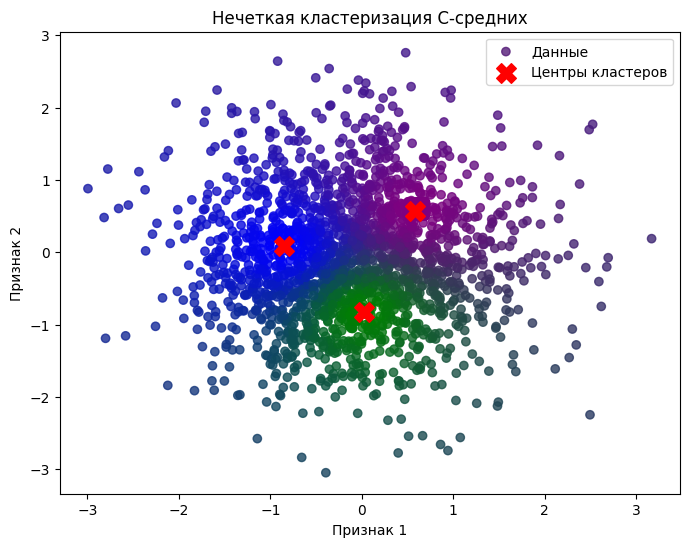

In [95]:
# Визуализация результатов
fig, ax = plt.subplots(figsize=(8, 6))
colors = ['blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray'][:num_clusters]
norm = mcolors.Normalize(vmin=0, vmax=1)

# Создание смешанных цветов для точек
point_colors = [blend_colors(U[:, i], colors) for i in range(data.shape[0])]

# Отображение данных и центроидов
ax.scatter(data[:, 0], data[:, 1], color=point_colors, alpha=0.8, label='Данные')
ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Центры кластеров')

# Настройка графика
ax.set_title('Нечеткая кластеризация C-средних')
ax.set_xlabel('Признак 1')
ax.set_ylabel('Признак 2')
ax.legend()
plt.show()

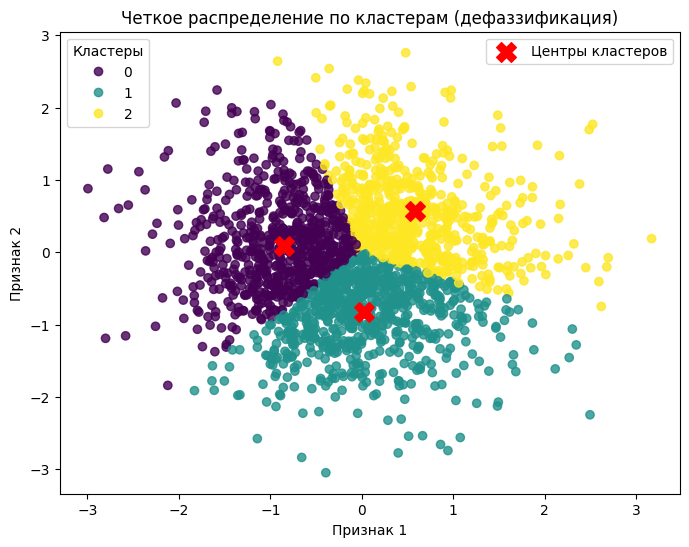

In [96]:
# Дефаззификация - определение основного кластера для каждой точки
clusters = defuzzification(U)

# Визуализация четкого распределения по кластерам
plt.figure(figsize=(8, 6))
scatter = plt.scatter(data[:, 0], data[:, 1], c=clusters, cmap='viridis', alpha=0.8)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200, label='Центры кластеров')

# Добавление легенды для кластеров
legend1 = plt.legend(*scatter.legend_elements(), title="Кластеры")
plt.gca().add_artist(legend1)

plt.title('Четкое распределение по кластерам (дефаззификация)')
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.legend()
plt.show()